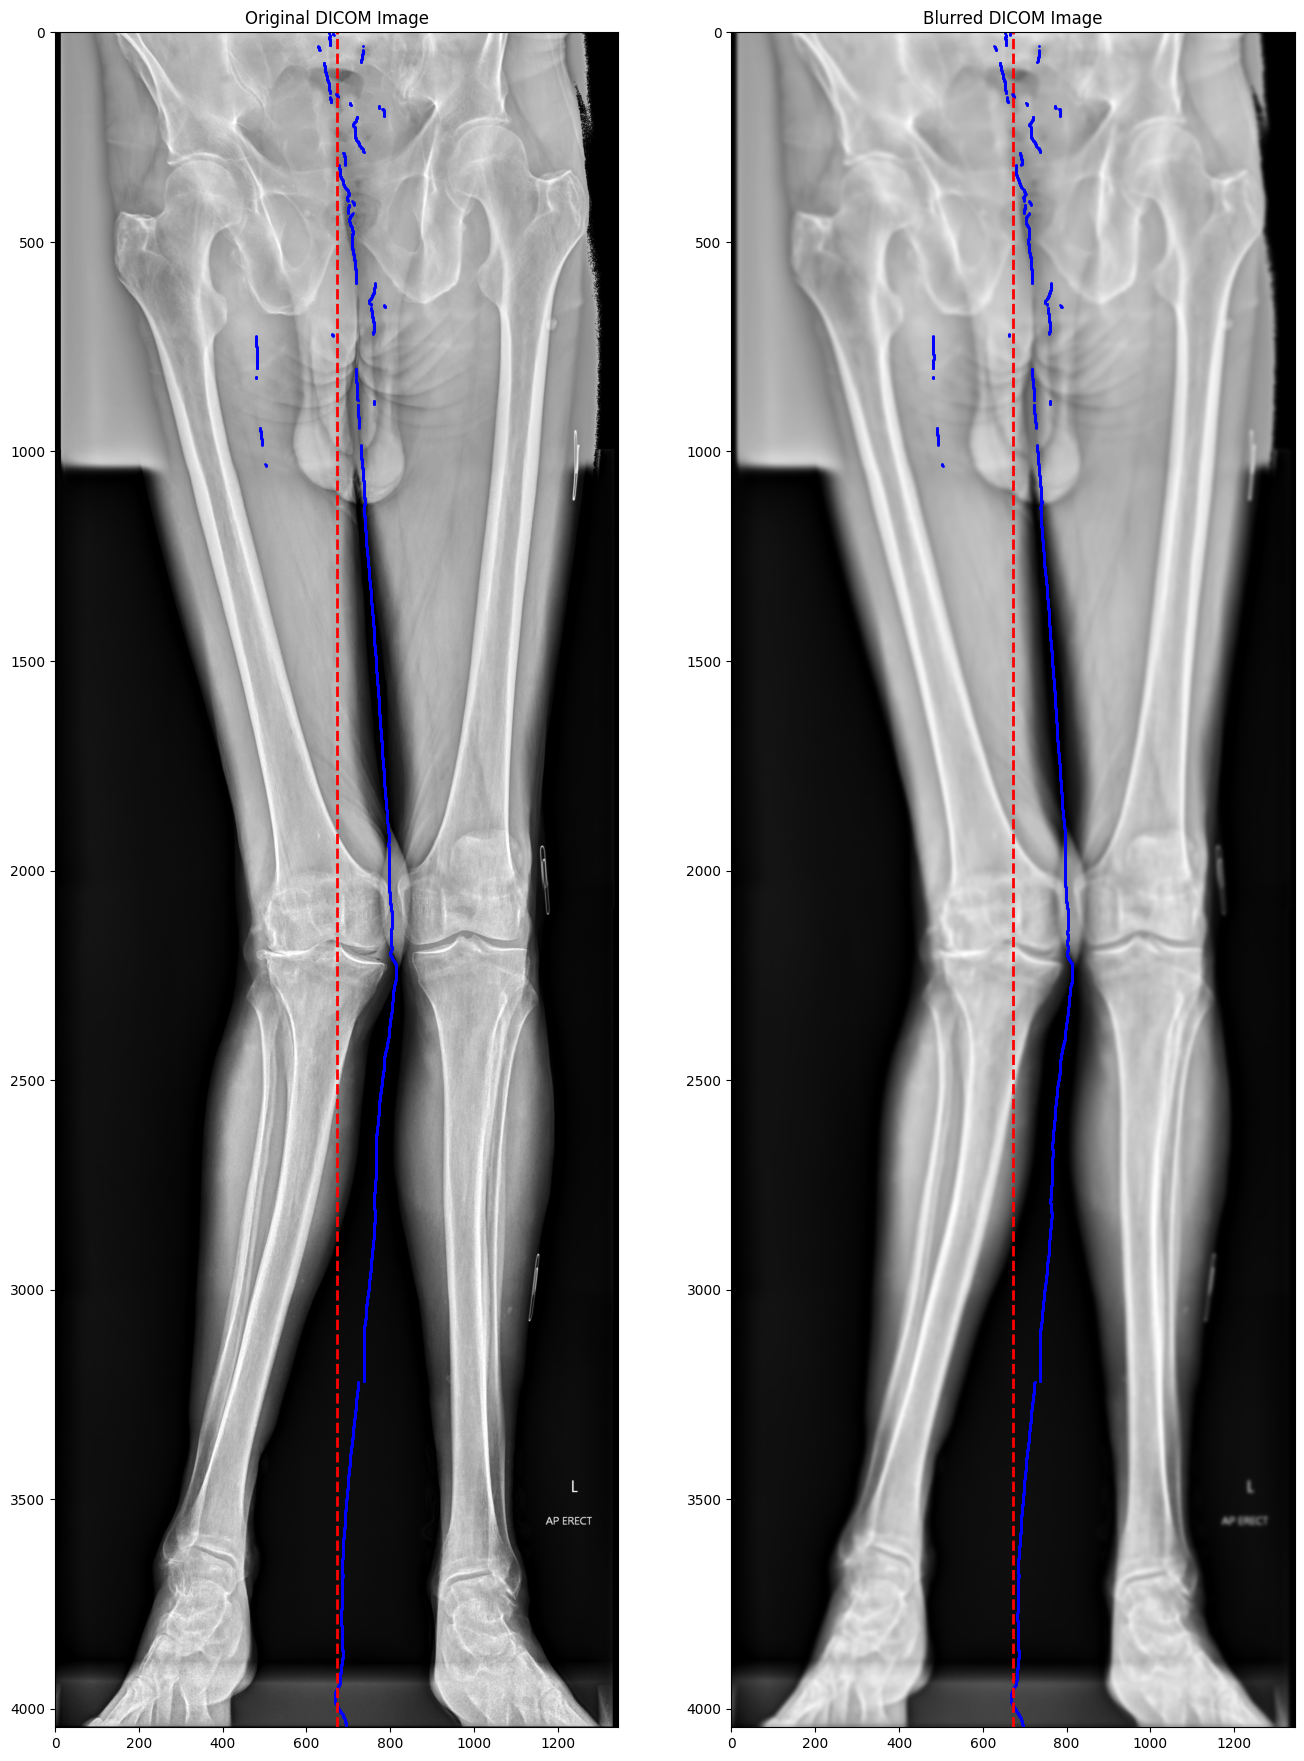

In [1]:
from joblib import Parallel, delayed
import numpy as np
import cv2
import pydicom
import matplotlib.pyplot as plt

# Load the DICOM file (assuming the file path is correct)
dicom_file_path = 'Js-IM-0039-0005.dcm'
dicom_data = pydicom.dcmread(dicom_file_path)

# Extract pixel data
pixel_data = dicom_data.pixel_array.astype(float)

# Apply Gaussian blur to reduce noise
blur_radius = 25  # You can adjust the blur radius as needed
blurred_image = cv2.GaussianBlur(pixel_data, (blur_radius, blur_radius), 0)

# Get dimensions of the array
rows, cols = pixel_data.shape
size = cols // 3  # (half) size of symmetry inspection window

# Precompute sliding windows for each row
def compute_symmetry_line(row, blurred_image, size):
    """Function to compute the symmetry line for a given row."""
    left_arrays = np.lib.stride_tricks.sliding_window_view(blurred_image[row, :cols - size], size)
    right_arrays = np.lib.stride_tricks.sliding_window_view(blurred_image[row, size:], size)[:, ::-1]
    
    # Calculate sum of squared differences for each column pair
    diff_squares = np.sum((left_arrays - right_arrays) ** 2, axis=1)
    
    # Find the index with minimum sum of squares
    min_idx = np.argmin(diff_squares) + size
    
    # Return the result
    return min_idx

# Use parallel processing to compute the symmetry line for each row
r = Parallel(n_jobs=-1)(delayed(compute_symmetry_line)(row, blurred_image, size) for row in range(rows))

# Post-processing to ensure symmetry line progresses towards darker regions
for row in range(1, rows):
    if pixel_data[row, int(r[row])] > 2 * pixel_data[row - 1, int(r[row - 1])]:
        r[row] = r[row - 1]

# Display the original and blurred images along with symmetry lines
plt.figure(figsize=(16, 30))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(pixel_data, cmap=plt.cm.gray)
plt.title("Original DICOM Image")
plt.scatter(r, np.arange(len(r)), marker='o', color='blue', s=1)
plt.axvline(x=cols / 2, color='red', linestyle='--', linewidth=2, label='Vertical midline')

# Blurred Image
plt.subplot(1, 2, 2)
plt.imshow(blurred_image, cmap=plt.cm.gray)
plt.title("Blurred DICOM Image")
plt.scatter(r, np.arange(len(r)), marker='o', color='blue', s=1)
plt.axvline(x=cols / 2, color='red', linestyle='--', linewidth=2, label='Vertical midline')

plt.show()